# This assignment was completed by 

Bevan Fairleigh 219296864

Rao Siddhant Yadav 220384895

Chris Chong 220178171

### for Deakin University SIT789 T2 2021
### Applications of Computer Vision and Speech Processing
### 4.3P Image Recognition System

In [1]:
## Set up

import numpy as np
import cv2 as cv
import os
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2 as cv


from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier



In [2]:
# Creating list of file names and labels of all training images

path = 'dataset2/'

subpaths = ["/test/","/train/","/validate/"]
class_labels = os.listdir(path+subpaths[1])
print(class_labels)

training_file_names = []
training_labels = []
for i in range(0, len(class_labels)):
    sub_path = path + 'train/' + class_labels[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    training_file_names += sub_file_names
    training_labels += sub_labels

# Creating list of file names and labels of all validation images
validate_file_names = []
validate_labels = []
for i in range(0, len(class_labels)):
    sub_path = path + 'validate/' + class_labels[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    validate_file_names += sub_file_names
    validate_labels += sub_labels
    
# Creating list of file names and labels of all test images
test_file_names = []
test_labels = []
for i in range(0, len(class_labels)):
    sub_path = path + 'test/' + class_labels[i] + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    sub_labels = [i] * len(sub_file_names)
    test_file_names += sub_file_names
    test_labels += sub_labels

['butterfly', 'dugong', 'frog', 'goldfish']


In [3]:
for i in random.sample(range(0, 100), 2):
    print(training_file_names[i])
    print(training_labels[i])
    print(validate_file_names[i])
    print(validate_labels[i])
    print(test_file_names[i])
    print(test_labels[i])

dataset2/train/butterfly/n02279972_89.JPEG
0
dataset2/validate/dugong/n02074367_140.JPEG
1
dataset2/test/dugong/n02074367_220.JPEG
1
dataset2/train/dugong/n02074367_102.JPEG
1
dataset2/validate/dugong/n02074367_18.JPEG
1
dataset2/test/dugong/n02074367_248.JPEG
1


Training image samples


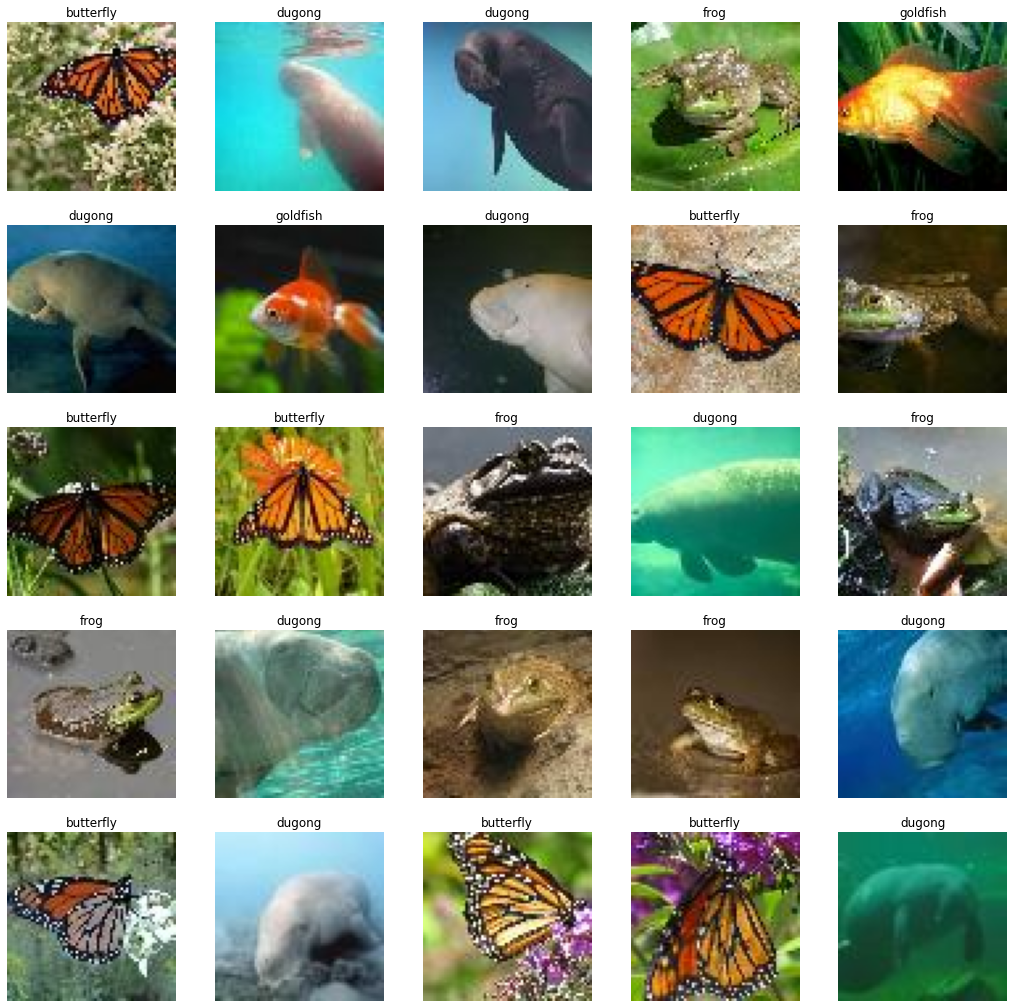





Validation image samples


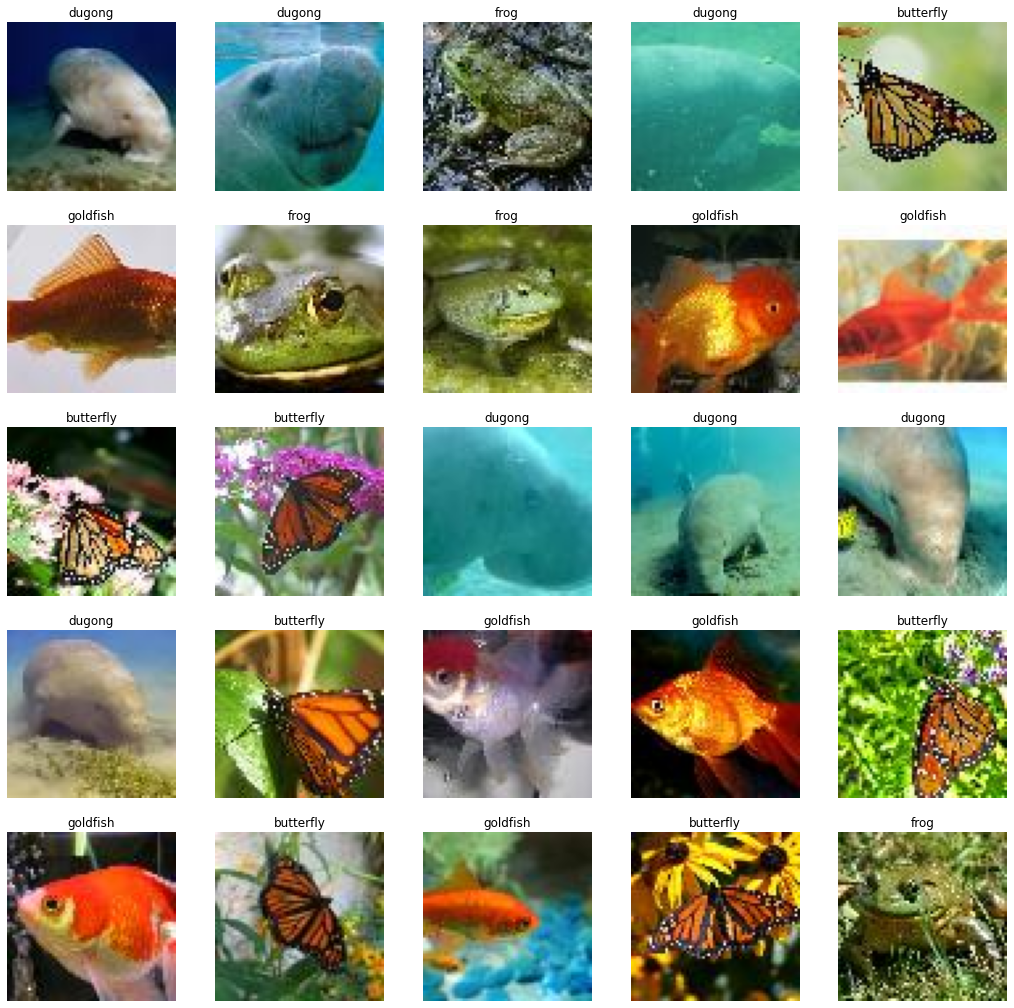





Testing image samples


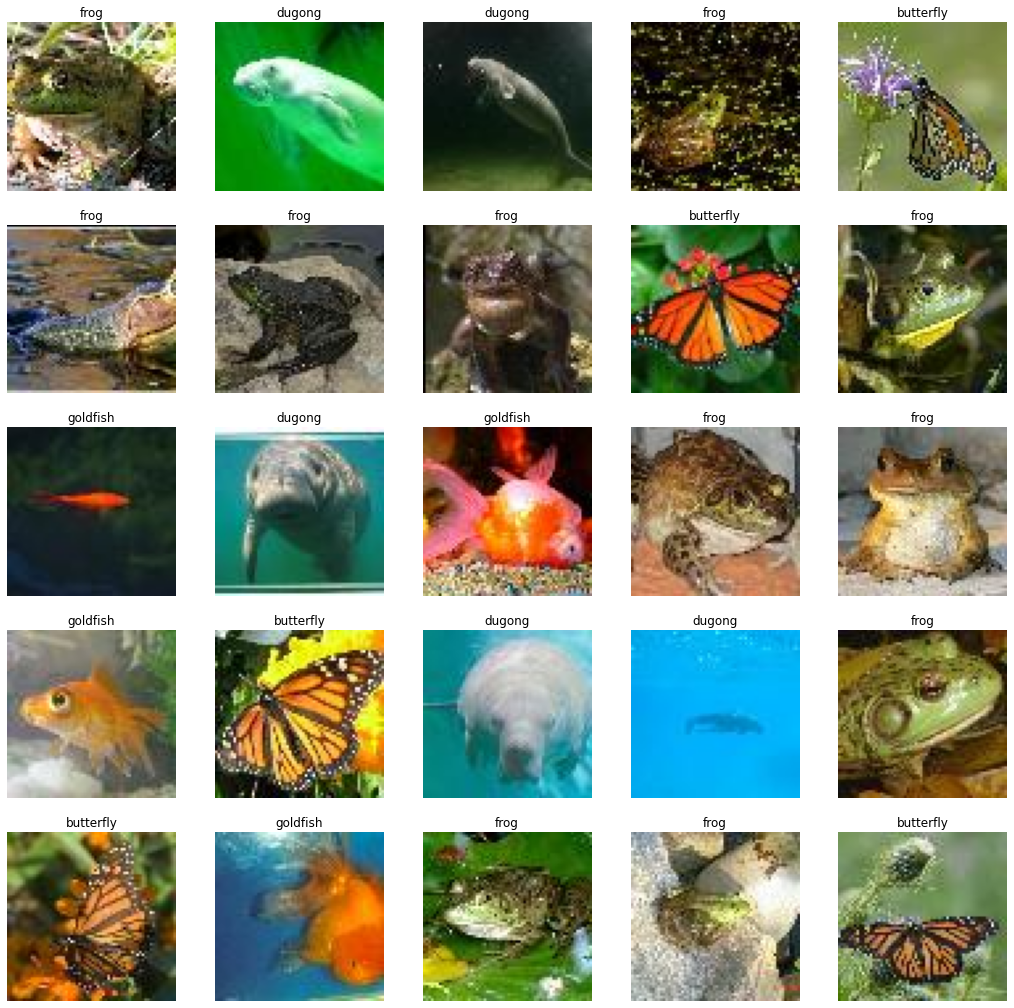

In [4]:

#Simple plot function to show 25 samples of each imageset
def plot(image_class,images):
    f, axarr = plt.subplots(5,5, figsize=(18,18))
    counter = 0
    for i in range(5):
      for j in range(5):
        image = cv.imread(images[counter])
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        axarr[i,j].imshow(image)
        axarr[i,j].axis('off')
#         title = (class_labels[image_class[counter]]+'\n'+images[counter][8:])
        title = (class_labels[image_class[counter]])
        axarr[i,j].set_title(title)
        counter = counter+1
    plt.show()
    print('\n\n\n')

# Sample of Training Images
num_rows = np.shape(training_file_names)[0]
images = []
image_class = []
index_value = random.sample(list(enumerate(training_file_names)), 25)
for idx, val in index_value:
    image_class.append(training_labels[idx])
    images.append(val)
print("Training image samples")
plot(image_class,images)


# # Sample of Validation Images
num_rows = np.shape(validate_file_names)[0]
images = []
image_class = []
index_value = random.sample(list(enumerate(validate_file_names)), 25)
for idx, val in index_value:
    image_class.append(validate_labels[idx])
    images.append(val)
print("Validation image samples")
plot(image_class,images)

# # Sample of Test Images
num_rows = np.shape(test_file_names)[0]
images = []
image_class = []
index_value = random.sample(list(enumerate(test_file_names)), 25)
for idx, val in index_value:
    image_class.append(test_labels[idx])
    images.append(val)
print("Testing image samples")
plot(image_class,images)

## 2. Building and Image Recognition System
### 2.1 Building BoW Model

In [5]:

# 1. Bag-of-Words (BoW) model

import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans

#Configure our dictionary class
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
 
    def learn(self):
        sift = cv.xfeatures2d.SIFT_create()
        
        num_keypoints = [] #this is used to store the number of keypoints in each image
 
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
 
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words) #num_words is number of clusters
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
 
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
 
        return training_word_histograms
 
    def create_word_histograms(self, img_filenames):
        sift = cv.xfeatures2d.SIFT_create()
        histograms = []
        
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
 
                    histogram[matching_word_ID] += 1
 
                histogram /= len(descriptors) #normalise histogram to frequencies
 
            histograms.append(histogram)
    
        return histograms


In [6]:
# Building an Image Recognition System

sift = cv.xfeatures2d.SIFT_create()
num_keypoints = [] 
training_data = []
 
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)



run time = 10.61365890900294 minutes


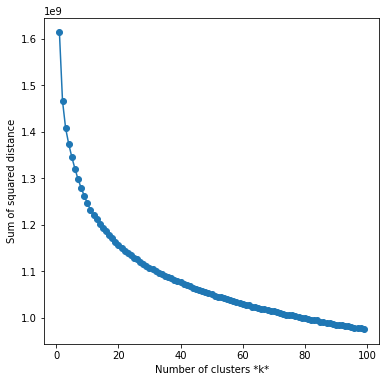

In [7]:
# K- means elbow test
# Let's see if we can discover an optimum value for K via k-means clustering, selecting values based on elbow

sse = []
list_k = list(range(1, 100))
start_time = time.time()
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(training_data)
    sse.append(km.inertia_)
    
# Plot sse against k
end_time = time.time()
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
print('run time =',(end_time-start_time)/60,'minutes')

## 2.1. Building Classifiers
### Preprocessing

In [28]:

# BoW model and creating dictionary.

# array to store the image paths
validate_file_names = []
# array for true labels based on the folder name
validate_labels = []


for subdir, dirs, files in os.walk(path+'validate/'):
    for file in files:
        filepath = subdir+'/'+file
        validate_file_names.append(filepath)
        for i in class_labels:
            if subdir == (path+'validate/'+i):
                validate_labels.append(class_labels.index(i))

                
## Given our k-means clustering gave us unclear 'elbow'
## 11 was selected for giving the highest accuracy across all models
num_words = 20                
                
dictionary_name = 'dictionary'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

# Learning the dictionary
training_word_histograms = dictionary.learn()

# we now have a built dictionary

# extract the word histogram for the images
word_histograms = dictionary.create_word_histograms(validate_file_names)



### 2.1.1 k-NN Classifier

In [29]:
#Best overall scores for Knn
best_accuracy_knn = 0
best_k = 0

print("K-NN Results")

# iterate through different numbers of nearest neighbours
num_nearest_neighbours = [5, 10, 15, 20, 25, 30]

for n in num_nearest_neighbours:
    #Best candidate scores
    cand_accuracy_knn = 0
    cand_k = 0
    knn = KNeighborsClassifier(n_neighbors = n)
    # Train on TRAINING set
    knn.fit(training_word_histograms, training_labels)
    predicted_labels = knn.predict(word_histograms)

    if accuracy_score(validate_labels, predicted_labels) > cand_accuracy_knn:
        cand_accuracy_knn = accuracy_score(validate_labels, predicted_labels)
        cand_k = n
        if cand_accuracy_knn > best_accuracy_knn:
            best_accuracy_knn = cand_accuracy_knn
            best_k = cand_k

    print(f"Candidate: Nearest Neighbours = {cand_k}, Accuracy = {cand_accuracy_knn:.3}")
print("---------")
print(f"Best: Nearest Neighbours = {best_k}, Accuracy = {best_accuracy_knn:.3}")


K-NN Results
Candidate: Nearest Neighbours = 5, Accuracy = 0.412
Candidate: Nearest Neighbours = 10, Accuracy = 0.421
Candidate: Nearest Neighbours = 15, Accuracy = 0.433
Candidate: Nearest Neighbours = 20, Accuracy = 0.45
Candidate: Nearest Neighbours = 25, Accuracy = 0.454
Candidate: Nearest Neighbours = 30, Accuracy = 0.471
---------
Best: Nearest Neighbours = 30, Accuracy = 0.471


### 2.1.2 Linear SVM Classifier

In [30]:
#Best overall scores for SVM
best_accuracy_SVM = 0
best_c = 0
print("SVM Results")
print("---------")
    
# iterate through different C values
C = [0.1, 1, 10, 100, 200]

for i in C:
    #Best candidate scores
    cand_accuracy_SVM = 0
    cand_c = 0
    svm_classifier = svm.SVC(C = i, kernel = 'linear')
    # Train on TRAINING set
    svm_classifier.fit(training_word_histograms, training_labels)
    predicted_labels = svm_classifier.predict(word_histograms)

    if accuracy_score(validate_labels, predicted_labels) > cand_accuracy_SVM:
        cand_accuracy_SVM = accuracy_score(validate_labels, predicted_labels)
        cand_c = i
        if cand_accuracy_SVM > best_accuracy_SVM:
            best_accuracy_SVM = cand_accuracy_SVM
            best_c = cand_c
            
    print(f"Candidate: C = {cand_c}, Accuracy = {cand_accuracy_SVM:.3}")
print("---------")
print(f"Best: C = {best_c}, Accuracy = {best_accuracy_SVM:.3}")



SVM Results
---------
Candidate: C = 0.1, Accuracy = 0.45
Candidate: C = 1, Accuracy = 0.5
Candidate: C = 10, Accuracy = 0.487
Candidate: C = 100, Accuracy = 0.492
Candidate: C = 200, Accuracy = 0.475
---------
Best: C = 1, Accuracy = 0.5


### 2.1.3 AdaBoost Classifier

In [31]:

best_accuracy_ada = 0
best_n = 0
    
# iterate through different n_estimators
n_estimators = [25,30,40,45,50, 100, 150, 200, 250, 300]
for i in n_estimators:
    
    #Best candidate scores
    cand_accuracy_ada = 0
    cand_n = 0
    adb_classifier = AdaBoostClassifier(n_estimators = i, #weak classifiers
                                        random_state = 0)
    # Train on TRAINING set
    adb_classifier.fit(training_word_histograms, training_labels)
    predicted_labels = adb_classifier.predict(word_histograms)

    if accuracy_score(validate_labels, predicted_labels) > cand_accuracy_ada:
        cand_accuracy_ada = accuracy_score(validate_labels, predicted_labels)
        cand_n = i
        if cand_accuracy_ada > best_accuracy_ada:
            best_accuracy_ada = cand_accuracy_ada
            best_n = cand_n

        print(f"Candidate: N Estimators = {cand_n}, Accuracy = {cand_accuracy_ada:.3}")
print("---------")
print(f"Best: N Estimators = {best_n}, Accuracy = {best_accuracy_ada:.3}")

    
    


Candidate: N Estimators = 25, Accuracy = 0.471
Candidate: N Estimators = 30, Accuracy = 0.45
Candidate: N Estimators = 40, Accuracy = 0.425
Candidate: N Estimators = 45, Accuracy = 0.429
Candidate: N Estimators = 50, Accuracy = 0.446
Candidate: N Estimators = 100, Accuracy = 0.479
Candidate: N Estimators = 150, Accuracy = 0.454
Candidate: N Estimators = 200, Accuracy = 0.487
Candidate: N Estimators = 250, Accuracy = 0.475
Candidate: N Estimators = 300, Accuracy = 0.496
---------
Best: N Estimators = 300, Accuracy = 0.496


## 2.2 Evaluating Classifiers
### 2.2.1 Comparison and Conclusions

In [32]:
# build the test set file names and corresponding labels

# array to store the image paths
test_file_names = []
# array for true labels based on the folder name
test_labels = []



for subdir, dirs, files in os.walk(path+'test/'):
    for file in files:
        filepath = subdir+'/'+file
        test_file_names.append(filepath)
        for i in class_labels:
            if subdir == (path+'test/'+i):
                test_labels.append(class_labels.index(i))

# extract the word histogram for the images
test_word_histograms = dictionary.create_word_histograms(test_file_names)

In [33]:
# Remind ourselves of the best Hyperparameters

print(f"Best: Nearest Neighbours = {best_k}, Accuracy = {best_accuracy_knn:.3}")
print(f"Best: C = {best_c}, Accuracy = {best_accuracy_SVM:.3}")
print(f"Best: N Estimators = {best_n}, Accuracy = {best_accuracy_ada:.3}")


Best: Nearest Neighbours = 30, Accuracy = 0.471
Best: C = 1, Accuracy = 0.5
Best: N Estimators = 300, Accuracy = 0.496


In [34]:
# Evaluate all the three tuned models on the TEST set

test_Y=test_labels

# k-NN

knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(training_word_histograms, training_labels)
pred_y_knn = knn.predict(word_histograms) 


# SVM

svm_classifier = svm.SVC(C = best_c, kernel = 'linear') 
svm_classifier.fit(training_word_histograms, training_labels)
pred_y_svm = svm_classifier.predict(test_word_histograms)


# AdaBoost

adb_classifier = AdaBoostClassifier(n_estimators = best_n,random_state = 0)
adb_classifier.fit(training_word_histograms, training_labels)
pred_y_ada = adb_classifier.predict(test_word_histograms)


# Recognition Accuracy
acc_knn = accuracy_score(test_Y, pred_y_knn)
acc_svm = accuracy_score(test_Y, pred_y_svm)
acc_ada = accuracy_score(test_Y, pred_y_ada)



Recognition accuracy for k-NN Classifier: 47.08%
Best: Nearest Neighbours = 30
              precision    recall  f1-score   support

   butterfly       0.47      0.95      0.63        60
      dugong       0.64      0.27      0.38        60
        frog       0.39      0.33      0.36        60
    goldfish       0.47      0.33      0.39        60

    accuracy                           0.47       240
   macro avg       0.49      0.47      0.44       240
weighted avg       0.49      0.47      0.44       240



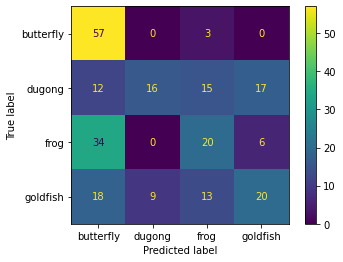

In [35]:

print(f'Recognition accuracy for k-NN Classifier: {acc_knn*100:.2f}%')
print(f"Best: Nearest Neighbours = {best_k}")
print(classification_report(test_labels, pred_y_knn, target_names=class_labels))

cm = confusion_matrix(test_labels, pred_y_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot()


Recognition accuracy for SVM Classifier: 52.08%
Best: C = 1
              precision    recall  f1-score   support

   butterfly       0.54      0.87      0.66        60
      dugong       0.58      0.42      0.49        60
        frog       0.44      0.48      0.46        60
    goldfish       0.56      0.32      0.40        60

    accuracy                           0.52       240
   macro avg       0.53      0.52      0.50       240
weighted avg       0.53      0.52      0.50       240



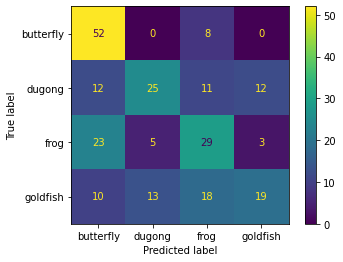

In [36]:
print(f'Recognition accuracy for SVM Classifier: {acc_svm*100:.2f}%')
print(f"Best: C = {best_c}")
print(classification_report(test_labels, pred_y_svm, target_names=class_labels))

cm = confusion_matrix(test_labels, pred_y_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot()

Recognition accuracy for Adaboost Classifier: 47.50%
Best: N Estimators = 300
              precision    recall  f1-score   support

   butterfly       0.61      0.65      0.63        60
      dugong       0.57      0.48      0.52        60
        frog       0.42      0.48      0.45        60
    goldfish       0.30      0.28      0.29        60

    accuracy                           0.48       240
   macro avg       0.48      0.47      0.47       240
weighted avg       0.48      0.47      0.47       240



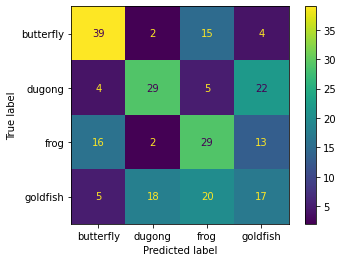

In [37]:
print(f'Recognition accuracy for Adaboost Classifier: {acc_ada*100:.2f}%')
print(f"Best: N Estimators = {best_n}")
print(classification_report(test_labels, pred_y_ada, target_names=class_labels))

cm = confusion_matrix(test_labels, pred_y_ada)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_labels)
disp.plot()


| Classifier   | Tuned Hyperparameter Value  | Recognition Accuracy (%)|
|---|---|---|
| k-NN  | num_nearest_neighbours =  30 | 47.08%  |
| Linear SVM  | C = 1  | 52.08%  |
| AdaBoost  | n_estimators = 300  | 47.55%  |

